In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import scipy
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import tqdm

%run ../Scripts/trajectory.py
%run ../Scripts/trajectoryVisual.py
%run ../Scripts/trajsTree.py
%run ../Scripts/supMethods.py
%run ../Scripts/formulas.py
foldername = "../Data/test14"

In [21]:
with open(foldername + "/params.json") as json_file:
    params = json.load(json_file)
with open(foldername + "/sim_params.json") as json_file:
    sim_params = json.load(json_file)

In [22]:
t0 = 1000
tf = 2000
dt = 5
t_domain = np.arange(t0, tf, dt)

In [23]:
for t in t_domain:
    make_frame(foldername, t, save = True, margins=(-0.42, -0.42))

make_Gif(foldername, t_domain, typename = "time_plots")

In [24]:
for t in t_domain:
    n_i = scipy.sparse.load_npz(foldername+f"/sp_frame_n{t}.npz").todok()
    indexes = get_nonzero_w_repeats(n_i)
    means_gmm, covs_gmm, counts_gmm = fit_unknown_GMM(indexes,n_components=1, 
                                                      w = 1000, reg_covar=1e4)
    means, covs, counts = reduce_GMM(means_gmm, covs_gmm, counts_gmm)
    plot_Ellipses(n_i, t, means, covs, save = True,
                foldername = foldername, input_color = "teal", margins=(-0.42, -0.42))

make_Gif(foldername, t_domain, typename = "GMM_plots")

In [25]:
for t in t_domain:
    n_i = scipy.sparse.load_npz(foldername+f"/sp_frame_n{t}.npz").todok()
    indexes = get_nonzero_w_repeats(n_i)
    means_gmm, covs_gmm, counts_gmm = fit_unknown_GMM(indexes,n_components=1,
                                                       w = 1000, reg_covar=1e4)
    means, covs, counts = reduce_GMM(means_gmm, covs_gmm, counts_gmm)
    next_list = make_Treelist(t, means, covs, counts)
    
    if t == t0:
        init_list = next_list
        prev_list = next_list
        continue

    prev_list = link_Treelists(prev_list, next_list)
    prev_list = next_list

save_Treelist(foldername, init_list)
make_Gif(foldername, t_domain, typename = "GMM_plots")

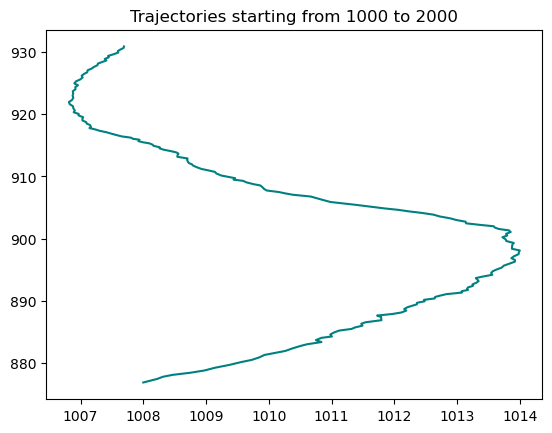

In [26]:
colors = generate_colors(len(init_list))
plt.figure()
plt.title(f"Trajectories starting from {t0} to {tf}")

for root_node, color in zip(init_list, colors):
    for trajs in root_node.get_all_traversals():
        try:
            positions = [x.mean for x in trajs]
            x_val, y_val = extract_xy(positions)
            plt.plot(x_val, y_val, color = "teal")
        except IndexError:
            print(positions)

plt.savefig(foldername+ "/trajectories.png")

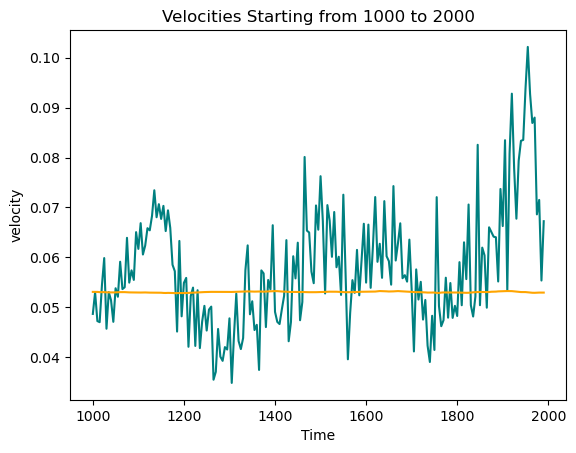

In [27]:
colors = generate_colors(len(init_list))
t_domain_np = np.array(t_domain)
plt.figure()
plt.title(f"Velocities Starting from {t0} to {tf}")

for root_node, color in zip(init_list, colors):
    for trajs in root_node.get_all_traversals():
        positions = [x.mean for x in trajs]
        time = [x.frame for x in trajs]
        time_avg = average_of_pairs(time)

        counts = np.array([x.count for x in trajs])
        counts_avg = average_of_pairs(counts)

        x_val, y_val = extract_xy(positions)
        if isinstance(x_val, np.ndarray):
            dt = np.diff(time)
            v_obs = np.sqrt(np.diff(x_val)**2 + np.diff(y_val)**2)/dt
            v_calc = calculate_velocity(counts_avg, params, sim_params)
            
            plt.plot(t_domain_np[:len(v_obs)], v_obs, color = 'teal')
            plt.plot(t_domain_np[:len(v_calc)], v_calc, color = 'orange')

# plt.ylim(0, 0.2)
plt.xlabel("Time")
plt.ylabel("velocity")
plt.savefig(foldername + "/velocity.png")

Text(0, 0.5, 'velocity')

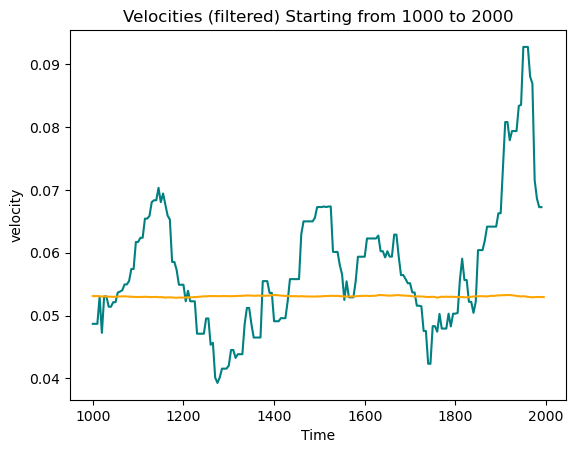

In [28]:
t_domain_np = np.array(t_domain)
plt.figure()
plt.title(f"Velocities (filtered) Starting from {t0} to {tf}")

for root_node, color in zip(init_list, colors):
    for trajs in root_node.get_all_traversals():
        positions = [x.mean for x in trajs]
        counts = np.array([x.count for x in trajs])
        x_val, y_val = extract_xy(positions)
        if isinstance(x_val, np.ndarray):
            v_obs = np.sqrt(np.diff(x_val)**2 + np.diff(y_val)**2)/dt
            v_obs_med = running_median_filter(v_obs, 5)
            v_calc = calculate_velocity(counts, params, sim_params)
            plt.plot(t_domain_np[:len(v_obs_med)], v_obs_med, color = 'teal')
            plt.plot(t_domain_np[:len(v_calc)], v_calc, color = 'orange')

# plt.ylim(0, 0.2)
plt.xlabel("Time")
plt.ylabel("velocity")